# Constructing the Method of Moment Matrix
# by Allowing ForwardDiff to Operate on QuadGK Output 

## Import Packages

In [2]:
using ForwardDiff
using QuadGK
using Plots 

## Section 1: Introduction 
<b>Motivation</b> We wish to generate the MoM matrix as the linear transformation matrix (sensitivity matrix, input-output matrix) mapping magnetization vector $\vec{M}(\vec{x})$ to the magnetic flux vector $\vec{B}(\vec{x})$ after spatial discretization (need to include magnetic field $\vec{H}(\vec{x})$). More precisely, we wish to develop a procedure that after spatial discretization (on a FEM mesh) goes through the following two steps: 
1. apply (adaptive) quadrature (including handling of singular integrals) to map $\vec{M}(\vec{x})$ to magnetic vector potential $\vec{A}(\vec{x})$;
2. apply automatic differentiation to differentiate the magnetic flux $\vec{B}(\vec{x}) = \vec{B}(\vec{A}(\vec{M})))$ wrt to $\vec{M}$ to obtain the MoM matrix;

More details of both steps will be outlined below. These steps focuss on the <b>generation</b> MoM matrix. Solving of the linear system with the MoM will be discussed elsewhere. 

<b>Potential Gains</b> We perceive the following gains 
1. allow automatic differentiation to perform half the work (do we need to pay a price (toll) later?); 
2. preserve order of computations as the math reads, i.e., first integration of the source domain, then differentiate in the destination variables. Code thus easier to read and maintain?;
3. avoid differentiating the integral, thus avoid increasing the singularity of the integrand? 
4. avoid splitting integral as a sum of multiple integrals; 
5. avoid replacing volume integrals $dx'\,dy'\,dz'$ over elements $e_k$ in the finite element mesh as sum of integrsals over faces of $e_k$ (how to compute singular integrals over tetrahedra?);  
6. show-case distinct use of multiple dispatch allowing to compose two Julia packages (cfr. earlier case of combined used of interval arithmetic and ODE solver by Chris Raukaucas);  

<b>Assumptions Made</b> We assume that 
1. the eventual computational overhead of adaptive quadrature (for singular intregrals on tetrahedra) can be amortized by thread-parallel computations (as shown earlier by the heroin in this project);
2. residual weighting of the MoM equations (weak or variational formulations) occurs using Dirac delta (pulse) functions (distribution). Residual weighting thus reduces to point matching; 

<b>Problem Description</b> More here. 

<b>One-Dimensional Case</b> In one spatial dimension ($x$-only), the vector valued problem reduces to a scalar problem. Given the magnitization vector $\vec{M}(\vec{x}) = (0,0,M_z(x))$, we wish to compute 
1. the magnetic vector potential $\vec{A}(\vec{x}) = (0,A_y(x),0)$ where 
$A_y(x) = \frac{\mu_0}{4 \pi} \int_a^b \frac{M_z(x) \, (x-x')}{|x-x'|^3} \, dx'$ using quadrature implemented in QuadGK.jl; 
2. the magnetic flux $\vec{B}(\vec{x}) = (0,0,B_z(x))$ where $B_z(x) = - \frac{\partial A_y(x)}{\partial x}$ using automatic differentiation implemented in ForwardDiff.jl;  

<b>Spatial Discretization of the One-Dimensional Case</b> Introduce computational mesh $\Omega^h$ of $N$ elements $e_k = [x_k, x_{k+1}]$ and $N+1$ nodes $x_i$ on the domain of computation $\Omega$. On $e_k$ linear nodal shape function $\phi_i(x)$ can be defined. Express numerical approximation to $M_z(x)$ as $M^h_z(x) = \sum_i m_i \, \phi_i(x)$. Denote $\vec{m}$ the (N+1)-dimensional vector (one per node) of the mesh. Replacing $M_z(x)$ as $M^h_z(x)$ in the expression for $A_y(x)$ yields $A^h_y(x)$. The evaluation of $A^h_y(x)$ in the nodes $x_i$ yields a (N+1)-dimensional vector $\vec{a}$. This vector depends on $\vec{m}$. We thus write $\vec{a}(\vec{m})$. Given its importance in later discussions, we emphasize the point by formulating $\vec{a}$ as a mapping from $R^{N+1}$ to $R^{N+1}$ mapping $\vec{m}$ to $\vec{a}(\vec{m})$. A similar discourse holds for $B_z(x)$ by first differentiating $A^h_y(x)$ wrt to $x$ and then point-evaluation (order obviously matters here). We again obtain a mapping from $R^{N+1}$ to $R^{N+1}$ mapping $\vec{m}$ this time to $\vec{b}[\vec{a}(\vec{m})]$. The Jacobian of this mapping wrt $\vec{m}$ is the much desired $(N+1)-by-(N+1)$ MoM matrix.   

<b>Three-Dimensional Mesh Generation</b> To be discussed.

<b>Spatial Discretization of the Three-Dimensional Case</b> To be discussed. 

<b>Julia Packages Used</b>
We will use the following two packages: 
1. [QuadGK.jl](https://juliamath.github.io/QuadGK.jl/stable/) for adaptive quadrature (requires context on quadrature on meshesw in Julia - ask our heroin for first draft); 
2. [ForwardDiff.jl](https://juliadiff.org/ForwardDiff.jl/stable/) for automatic differentiation (requires context on automatic differentiation in Julia - ask our heroin for first draft); 

The magic resides in the multiple dispatch that allows to chain QuadGK.jl and ForwardDiff.jl.

<b>Notation</b> In the following xp stands for xprime.



## Section 2: QuadQK, ForwardDiff and Their Combined Use 

### Section 1.2: Examples of QuadQK 
Small example of QuadQK. Singular integrals on purpose avoided (see next Section). Outputs integral value and error. Morer later (amount of function evaluations). 

In [8]:
# define single input integrand
integrand(x) = x^2 

I = quadgk(x -> integrand(x), 0, 1)

(0.3333333333333333, 0.0)

### Section 2.2: Examples of ForwardDiff  
Small examples of ForwardDiff. More later (Jacobian and preallocating memory for dense Jacobian). 

In [9]:
ForwardDiff.derivative(x -> x^3, 1)

3

### Sectiion 3.2: Example of Derivate of an Integral 
Small example of derivative of an integral. More later. 

In [10]:
# define two input integrand
integrand(x,xp) = x - xp

# compute integral by quadrature over second input - results in u(x) = x - 0.5
u(x) = quadgk(xp -> integrand(x,xp), 0, 1)

# compute derivative - should result in du/dx = 1
ForwardDiff.derivative(x -> u(x)[1], 1)

1.0

## Section 3: QuadQK for Singular Integrals  
See [QuadQK.jl](https://juliamath.github.io/QuadGK.jl/stable/). 

## Section 4: Explicit (or Direct) Construction - Assume Magnetic Sources Known - Compute Magnetic Flux  

### Section 1.4: Synthetic Example Showing the Derivate of an Integral 
The following example was constructed to allow a closed-form analytical solution. 

1.0

### Section 2.4: Synthetic Example Showing What Goes in Case of Singular Kernels 
The following exanmple was constructed to illustrate difficulties with singular kernels. 

In [83]:
# define two input integrand
integrand(x,xp) = (x-xp)/abs(x - xp)^1.5

# compute integral by quadrature over second input - results in u(x) = x - 0.5
u(x) = quadgk(xp -> integrand(x,xp), 0, 1)

# compute derivative - should result in du/dx = 1
ForwardDiff.derivative(x -> u(x)[1], 1)

-9.514789506324105e7

### Section 3.4: Assume $M_z(x) = 1$ between $x=0.4$ and $x=0.6$

In [84]:
# define two input integrand
aa = 0.4; bb = 0.6; 
vpdens(x,xp) = ((x>aa)*(x<bb))*(x-xp)/abs(x - xp)^1.5

N = 100; h = 1/N; Np1 = N+1; 
xs = Vector(0:h:1)

# compute integral by quadrature over second input 
vpp = Array{Function}(undef, N-1)
for i =1:N-1
   vpp[i] = x -> quadgk(xp -> vpdens(x,xp), xs[i], xs[i+1])[1]
end 

# compute derivative 
#b(x) = ForwardDiff.derivative(x -> vpp[1](x)[1])

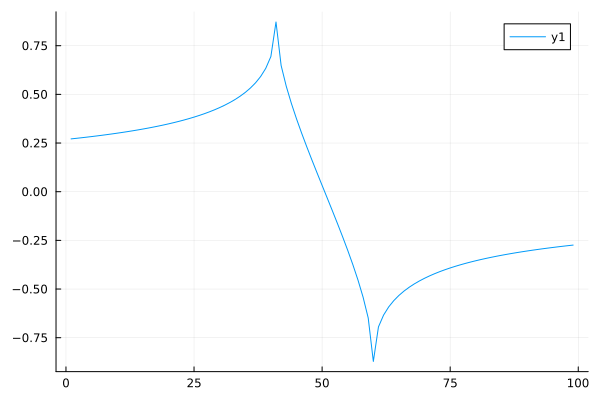

In [85]:
vpps = sum.([vpp[k].(xs) for k=1:N-1])
plot(vpps)

## Section 5: Implicit (or Inverse) Construction - Derive the MoM Transformation Matrix - Given the Magnetic Flux - Compute the Magnetic Sources 

In [86]:
vp

vp (generic function with 2 methods)

### Section 1.5: Synthetic Example Using Smooth Kernel 

In [87]:
# define the vector potential density as magnetization times kernel 
vpdens(x,xp,m) = (m[1]*sin(π*xp)+m[2]*cos(π*xp))*(x - xp)

# define the vector potential by integrating in the dummy xp over the magnetization domain  
vp(x,m) = quadgk(xp -> vpdens(x,xp,m), 0, 1)

# define the flux as the partial derivative of the potential wrt x (keeping m fixed)
b(x,m) = ForwardDiff.derivative(x -> vp(x,m)[1],x) 

b (generic function with 2 methods)

In [88]:
## sampling points in x and m 
xx = [.25, .75]
mm = [1., 2.]

# collocate the field on the grid in x - do point matching 
bsamp(m) = [b(xi,m) for xi in xx]

# compute the Jacobian  
ForwardDiff.jacobian(bsamp, mm) 

2×2 Matrix{Float64}:
 0.63662  3.77101e-17
 0.63662  3.77101e-17

## Section 6: Example of Jacobian of a Function in Multiple Variables
Can we re-formulate this example by reformulating the computation of $r[i]$ as 
$r[i] = \int_{x_{i-1}}^{x_{i+1}} u'_h(x) \, \phi'_i(x) \, dx $

In [89]:
function residual(m)
    r = similar(m)
    r[1] = m[1]
    for i=2:length(m)-1
        r[i] = -m[i-1] + 2*m[i] - m[i+1] 
    end 
    r[end] = m[end]
    return r
end

residual (generic function with 1 method)

In [90]:
m = ones(5)
r = residual(m)
display(r)

5-element Vector{Float64}:
 1.0
 0.0
 0.0
 0.0
 1.0

In [91]:
ForwardDiff.jacobian(residual, m) 

5×5 Matrix{Float64}:
  1.0   0.0   0.0   0.0   0.0
 -1.0   2.0  -1.0   0.0   0.0
  0.0  -1.0   2.0  -1.0   0.0
  0.0   0.0  -1.0   2.0  -1.0
  0.0   0.0   0.0   0.0   1.0